In [1]:
%matplotlib inline

from os import getenv
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from nifreeze.model.gpr import (
    compute_pairwise_angles,
    exponential_covariance,
    spherical_covariance,
)

# Use LaTeX for rendering
mpl.rcParams["text.usetex"] = True
# load the xfrac package
mpl.rcParams["text.latex.preamble"] = "\n".join(
    [
        mpl.rcParams["text.latex.preamble"],
        r"\usepackage{xfrac}",
    ]
)


PARAMETER_EXPONENTIAL_a = 0.5
"""a (angular distance), exponential kernel"""
PARAMETER_SPHERICAL_a = 1.38
"""a (angular distance), spherical kernel"""

PARAMETER_lambda = 1 / 2.1
"""λ (signal scaling factor)"""
PARAMETER_sigma2 = 0.5
"""σ² (noise adjustment, alpha in Scikit-learn's GP regressor)"""

"σ² (noise adjustment, alpha in Scikit-learn's GP regressor)"

# QA'ing the covariance model implementation

Compute the exponential and the spherical covariance function matrix values for angles between 0 and $\pi/2$. The length scale parameters are set to $a=1.23$ and $a=0.5$ for the spherical and the exponential functions respectively.

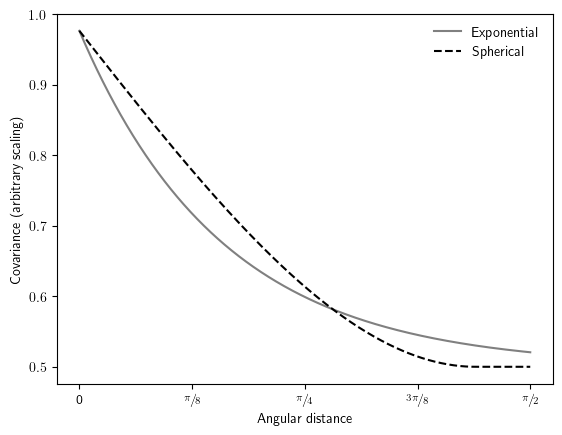

In [2]:
# Generate x-axis
theta_lin = np.linspace(0, np.pi / 2, num=1000)

# Calculate covariance functions
cov_exp = (
    PARAMETER_lambda * exponential_covariance(theta_lin, PARAMETER_EXPONENTIAL_a)
    + PARAMETER_sigma2
)
cov_sph = (
    PARAMETER_lambda * spherical_covariance(theta_lin, PARAMETER_SPHERICAL_a) + PARAMETER_sigma2
)

# Plot the exponential and spherical model covariances
plt.plot(theta_lin, cov_exp, "gray", label="Exponential")
plt.plot(theta_lin, cov_sph, "k--", label="Spherical")

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")

plt.legend(frameon=False);

## Extracting empirical covariances

Plot empirical covariances of all voxels within the brain mask from one HCP subject.

In [3]:
# Install test data from gin.g-node.org:
#   $ datalad install -g https://gin.g-node.org/nipreps-data/tests-nifreeze.git
# and point the environment variable TEST_DATA_HOME to the corresponding folder
DATA_PATH = Path(getenv("TEST_DATA_HOME", str(Path.home() / "nifreeze-tests")))
hcpdata = np.load(DATA_PATH / "hcpdata.npz")

b3000_mask = (hcpdata["bvals"] > 2500) & (hcpdata["bvals"] < 3500)
X_real = hcpdata["bvecs"][b3000_mask, ...]

In [4]:
triu_indices = np.triu_indices(b3000_mask.sum())

# Calculate pairwise empirical thetas and extract upper triangle
thetas_emp = compute_pairwise_angles(X_real, closest_polarity=True)[triu_indices]

In [5]:
# Standardize data, calculate covariance & extract upper triangle
y_real_original = hcpdata["b3000_data"]
y_real_mean = y_real_original.mean()
y_real = y_real_original - y_real_mean
y_real_std = y_real.std()
y_real /= y_real_std
# Calculate the covariance matrix.
y_cov = np.cov(y_real)

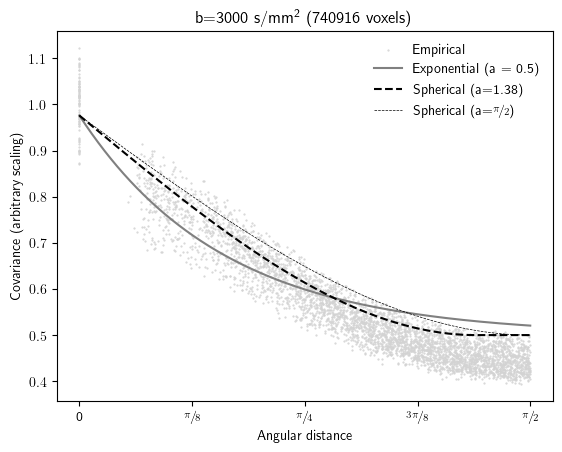

In [6]:
plt.scatter(thetas_emp, y_cov[triu_indices], s=0.3, c="lightgrey", label="Empirical")

# Plot the exponential and spherical model covariances
# Scale by a factor of 2 so that it matches Andersson2015's fig. 3.
plt.plot(theta_lin, cov_exp, "gray", label=f"Exponential (a = {PARAMETER_EXPONENTIAL_a})")
plt.plot(theta_lin, cov_sph, "k--", label=f"Spherical (a={PARAMETER_SPHERICAL_a})")
plt.plot(
    theta_lin,
    PARAMETER_lambda * spherical_covariance(theta_lin, 0.5 * np.pi) + PARAMETER_sigma2,
    "k--",
    lw=0.5,
    label="Spherical (a=$\\sfrac{\\pi}{2}$)",
)

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")
# plt.ylim(-1.05, 2.95)

plt.title(" ".join(("b=3000 s/mm$^\\text{2}$", f"({y_real.shape[1]} voxels)")))
plt.legend(frameon=False)
plt.savefig("covariance-plot.png", dpi=300, transparent=False, bbox_inches="tight");

## Checking the covariance of our simulated voxels

It seems our simulated voxels are too ideal.

In [7]:
from nifreeze.testing.simulations import simulate_voxels

NUM_VOXELS = 3000
BVAL_SHELL = 3000

data, gtab = simulate_voxels(
    S0=1000,
    evals=(0.0015, 0.0003, 0.0003),
    hsph_dirs=60,
    bval_shell=BVAL_SHELL,
    snr=8,
    n_voxels=NUM_VOXELS,
    seed=None,
)
X = gtab[~gtab.b0s_mask].bvecs
y = data[:, ~gtab.b0s_mask].T

triu_indices = np.triu_indices((~gtab.b0s_mask).sum())

# Calculate pairwise empirical thetas and extract upper triangle
synth_theta = compute_pairwise_angles(X, closest_polarity=True)[triu_indices]

# Calculate the covariance matrix and pick upper triangle.
y -= y.mean()
y /= y.std()
synth_cov = np.cov(y)[triu_indices]

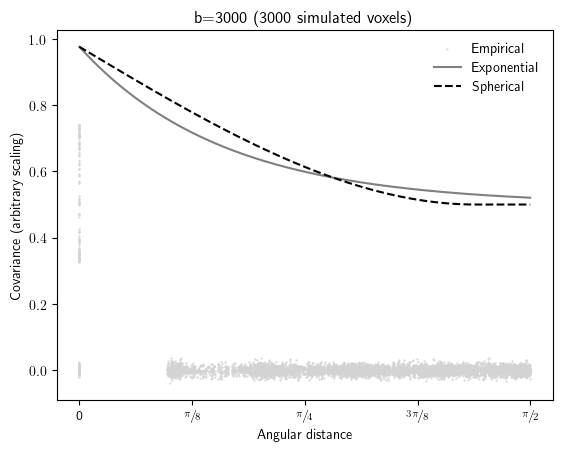

In [8]:
plt.scatter(synth_theta, synth_cov, s=0.3, c="lightgrey", label="Empirical")

# Plot the exponential and spherical model covariances
# Scale by a factor of 2 so that it matches Andersson2015's fig. 3.
plt.plot(theta_lin, cov_exp, "gray", label="Exponential")
plt.plot(theta_lin, cov_sph, "k--", label="Spherical")

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")

plt.title(f"b={BVAL_SHELL} ({y.shape[1]} simulated voxels)")
plt.legend(frameon=False)
plt.savefig("synthetic-covariance-plot.png", dpi=300, transparent=False, bbox_inches="tight");

## Modeling the HCP data

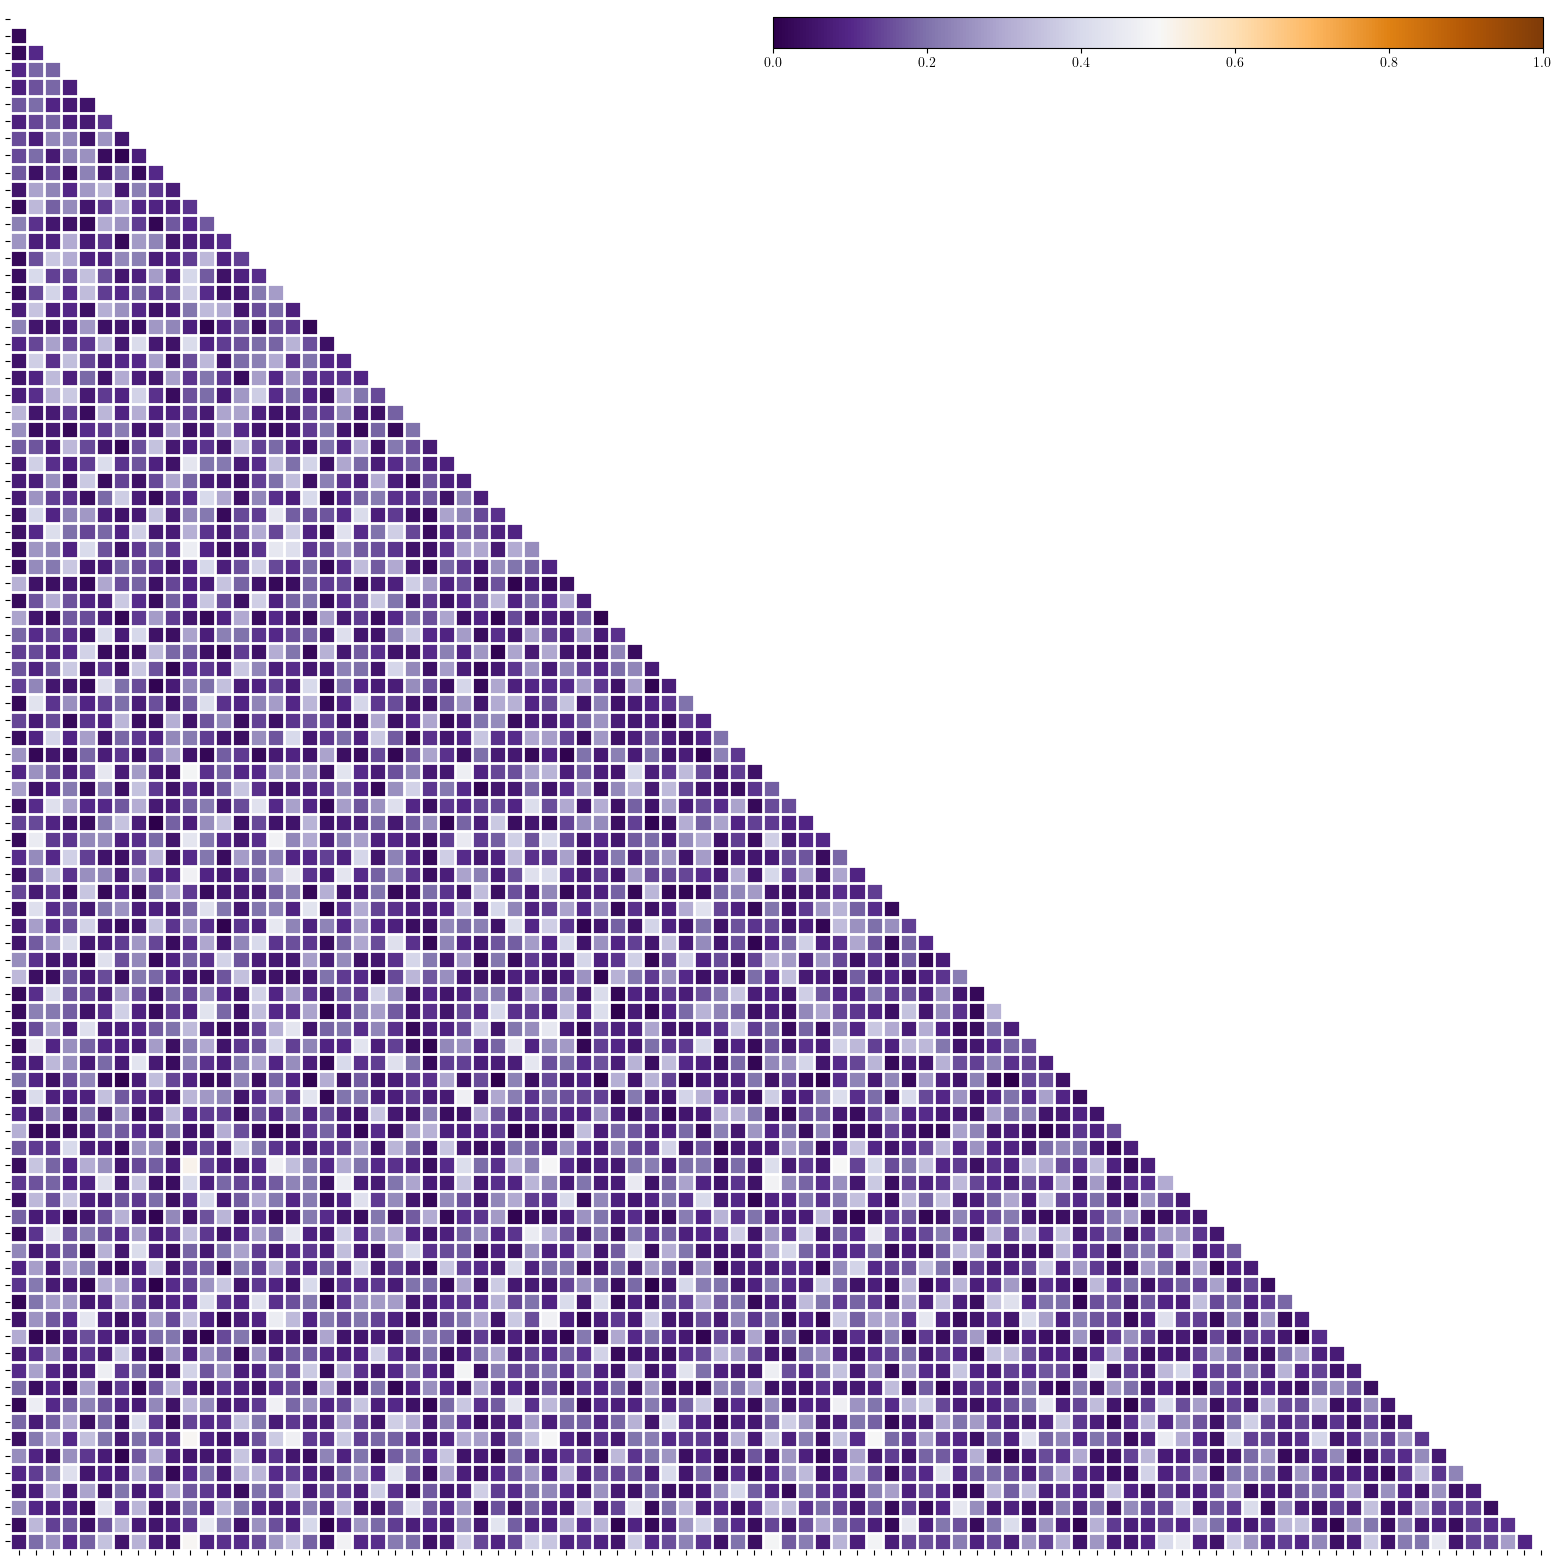

In [9]:
from mriqc_learn.viz.metrics import plot_corrmat

triu_indices = np.triu_indices(y_cov.shape[0])
plot_corrmat(y_cov.copy() - y_cov.min(), col_labels=[], figsize=(20, 20), vmin=0.0);

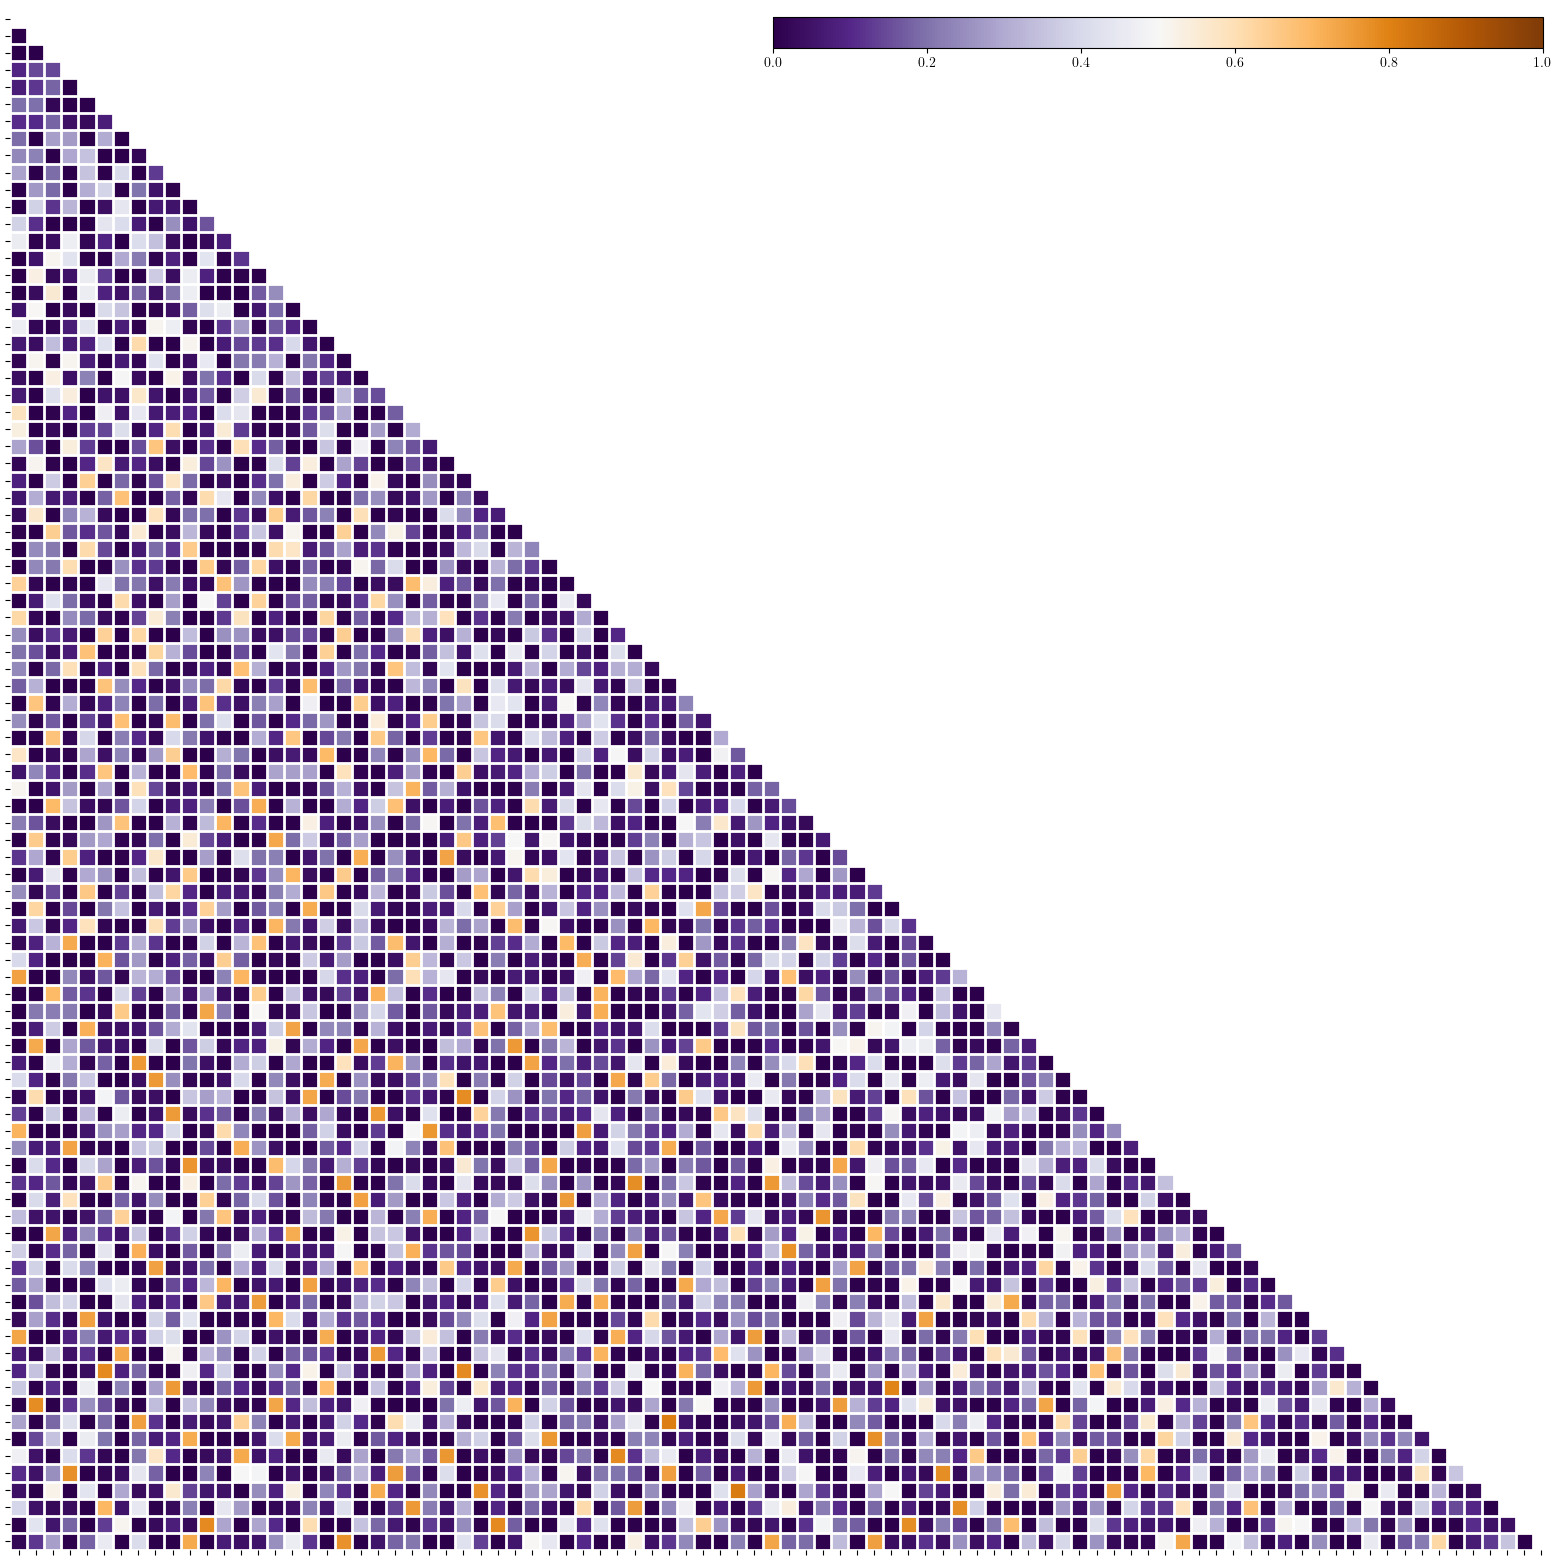

In [10]:
from nifreeze.model.gpr import DiffusionGPR, SphericalKriging

K = SphericalKriging(beta_a=PARAMETER_SPHERICAL_a, beta_l=PARAMETER_lambda)(X_real)
K -= K.min()
K /= K.max()
plot_corrmat(K.copy(), col_labels=[], figsize=(20, 20), vmin=K.min(), vmax=1);

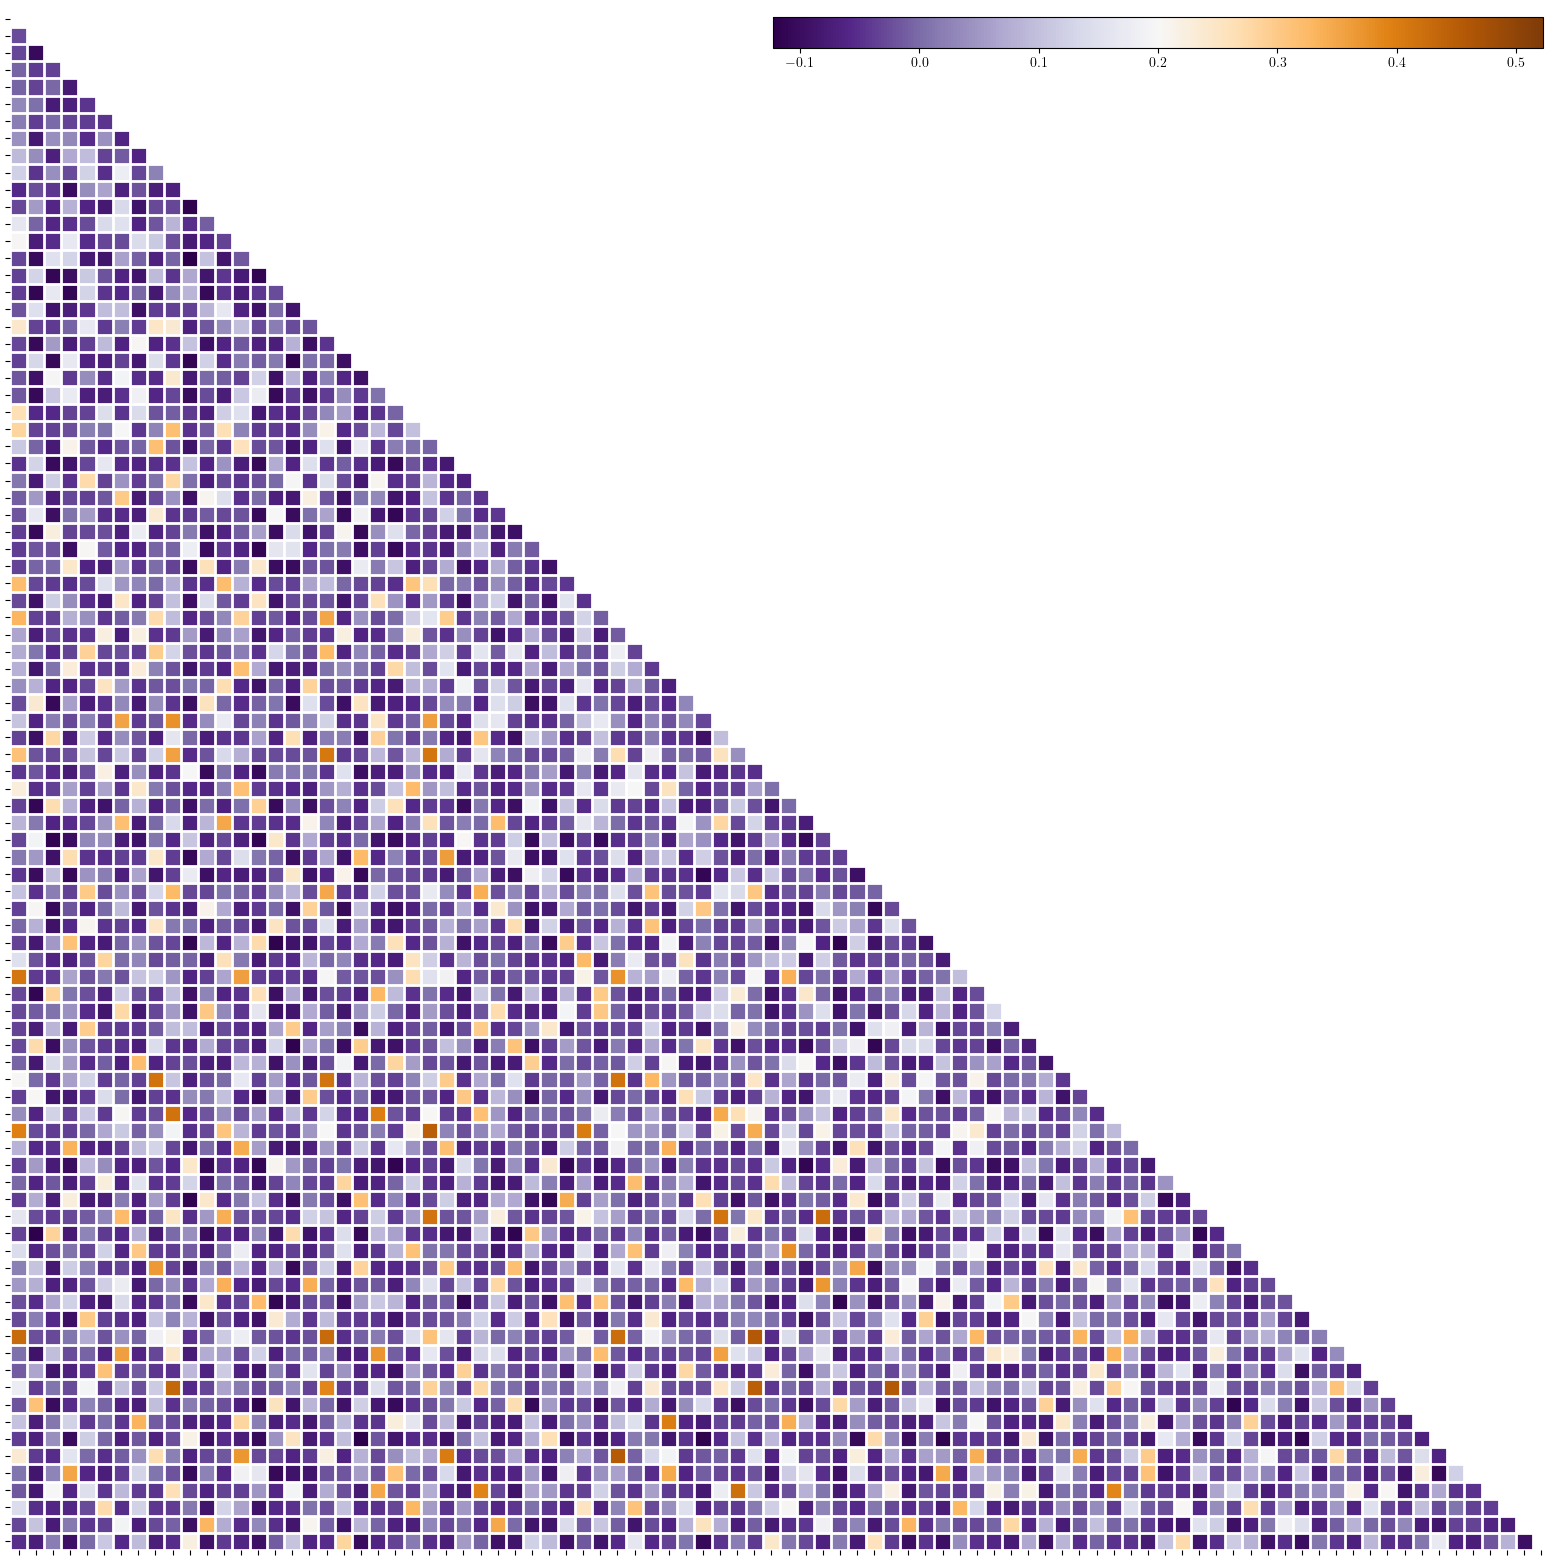

In [11]:
diff = K - (y_cov - y_cov.min())
plot_corrmat(diff.copy(), col_labels=[], figsize=(20, 20), vmin=diff.min(), vmax=diff.max());

In [12]:
gpm = DiffusionGPR(
    kernel=SphericalKriging(beta_a=PARAMETER_SPHERICAL_a, beta_l=PARAMETER_lambda),
    alpha=0.1,
    disp=True,
    optimizer="Nelder-Mead",
    ftol=1,
    gtol=1e-3,
    # maxiter=10,
)

In [13]:
fitted = gpm.fit(X_real, y_real_original)

Optimization terminated successfully.
         Current function value: 91641579.480447
         Iterations: 46
         Function evaluations: 90


## Test the covariance of predictions

Let's now replicate the plot above with the predictions from our model.
We predict on an out-of-sample set of b-vectors: the b-vectors of our synthetic voxels.

SphericalKriging (a=1.560657569361095, λ=2.6250477595075545)


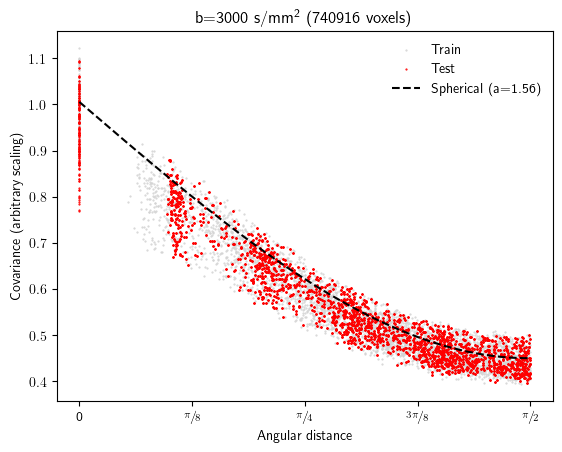

In [14]:
print(fitted.kernel_)

plt.scatter(thetas_emp, y_cov[triu_indices], s=0.3, c="lightgrey", label="Train")

predicted_y = fitted.predict(X)
predicted_y -= y_real_mean
predicted_y /= y_real_std
pred_cov = np.cov(predicted_y)

# Take σ² into account
pred_cov[np.diag_indices_from(pred_cov)] += fitted.alpha

# Calculate pairwise empirical thetas and extract upper triangle
thetas_pred = compute_pairwise_angles(X, closest_polarity=True)[
    np.triu_indices(predicted_y.shape[0])
]

plt.scatter(
    thetas_pred, pred_cov[np.triu_indices(predicted_y.shape[0])], s=0.3, c="red", label="Test"
)

# Plot the exponential and spherical model covariances
# Scale by a factor of 2 so that it matches Andersson2015's fig. 3.
beta_a = fitted.kernel_.beta_a
beta_l = fitted.kernel_.beta_l
plt.plot(
    theta_lin,
    spherical_covariance(theta_lin, beta_a) / 1.8 + 0.45,
    "k--",
    label=f"Spherical (a={beta_a:.02f})",
)

plt.xticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    ["0", r"$\sfrac{\pi}{8}$", r"$\sfrac{\pi}{4}$", r"$\sfrac{3\pi}{8}$", r"$\sfrac{\pi}{2}$"],
)

plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")
# plt.ylim(-1.05, 2.95)

plt.title(" ".join(("b=3000 s/mm$^\\text{2}$", f"({y_real.shape[1]} voxels)")))
plt.legend(frameon=False)
plt.savefig("covariance-plot.png", dpi=300, transparent=False, bbox_inches="tight");